## Data Analyst Test

#### General SQL Skills

You have a `sales` relational table that stores the simplified sales information of a given company. The table has the following `CREATE DDL` 

```mysql
CREATE TABLE `sales` (
  `order_id` varchar(32) NOT NULL,
  `username` varchar(64) NOT NULL,
  `order_date` datetime NOT NULL,
  `product_id` varchar(32) NOT NULL,
  `product_name` varchar(256) NOT NULL,
  `total_amount` decimal(6,2) NOT NULL,
  PRIMARY KEY (`order_id`),
  KEY `sales_idx_product_id` (`purchased_product_id`),
  KEY `sales_idx_username` (`client_username`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
```

The fields are self explainatory: they just represent **when** an order was made, **who** is the customer, **which** product they bought and the **amount** of the order.

This is a sample extract of this over simplified model:

**Table A**

| order_id | date                | username     | product_name  | total_amount |
| -------- | ------------------- | ------------ | ------------- | ------------ |
| 42-49    | 2019-07-01 15:05:25 | bob@me.com   | Ipad mini     | 449          |
| 78-12    | 2019-07-03 11:42:54 | jane@me.com  | **Ipad pro**  | 879          |
| 18-92    | 2019-07-01 17:22:10 | alice@me.com | **Ipad pro**  | 879          |
| 61-14    | 2019-06-02 10:11:43 | joe@me.com   | Ipad mini     | 449          |
| 84-34    | 2019-06-10 12:11:32 | bob@me.com   | AirPods       | 179          |
| 22-25    | 2019-05-15 15:10:10 | jane@me.com  | **Iphone Xs** | 939          |
| 52-49    | 2019-05-20 13:01:01 | joe@me.com   | Iphone 8      | 569          |
|          |                     |              |               |              |



The company wants an insight on the sales of the top Apple products the **Ipad pro** and the **Iphone Xs**, **aggregated by month**, so the first thing to do is to find a way to transform the table above into the following format:

**Table B**

| month | Ipad_pro_total | Iphone_xs_total | other_total |
| ----- | -------------- | --------------- | ----------- |
| 05    | 0              | 939             | 569         |
| 06    | 0              | 0               | 628         |
| 07    | 1758           | 0               | 449         |



**Questions**:

* Describe, using SQL statements, how you would transform **Table A** into **Table B**
* Would you use materialized tables or SQL Views?
* Is it possible to do this transformation using a single SQL statement?
* How would the transformation change if we wanted to group the sales by **week number**? And using the **name** of the month (ie. `July` instead of the **number** of the month `07`) ?



#### Data transformation and visualization

Given the example above, elaborate a short essay (15-20 sentences) where you answer the following:

* What kind of general-purpose analytic tools, programming languages or framework, scripting or data modeling tools you see fit to solve this particular task?
* What is your opinion on the `ETL` vs `ELT` dilemma? (hint: a quick Google search will shed some light)
* How would you visually present the results in **Table B**? What tool would you use for its visualization?


# Questions

<br>
<br>

## 1. Describe, using SQL statements, how you would transform Table A into Table B

<br>
<br>

&nbsp;&nbsp;&nbsp;&nbsp; I'll go step by step while explaining my thought process behind every query 


<br>

```mysql
SELECT strftime('%m',ORDER_DATE) AS months ,(SELECT 
(CASE WHEN PRODUCT_NAME = 'Iphone 8' or PRODUCT_NAME = 'Airpods'or PRODUCT_NAME = 'Ipad mini' 
 THEN 'Others' ELSE PRODUCT_NAME END)
 AS PRODUCT_NAME ) AS PRODUCTS ,  SUM(TOTAL_AMOUNT)
 FROM SALES2 
 GROUP BY PRODUCTS, months
 ORDER BY months

```

<br>

&nbsp;&nbsp;&nbsp;&nbsp;Gives me the following output : 



| months | PRODUCTS      |  SUM(TOTAL_AMMOUNT) |
| ----- | -------------- | ---------------     | 
| 05    |  IphoneXs      | 939                 |          
| 05    |  Others        | 569                 |          
| 06    |  Others        | 628                 |          
| 07    |  Ipad pro      | 1758                | 
| 07    |  Others        | 449                 | 


<br>

&nbsp;&nbsp;&nbsp;&nbsp; What I did there was basically select the month from the datetime variable and "rename" everything that's not an IphoneXs or an Ipad Pro to the others category, finnaly sum the total amount **grouped by product and  month** .   <br>

&nbsp;&nbsp;&nbsp;&nbsp; Now that I have this it's just a matter of pivoting the data ,there's no pivot function in SQLlite (SQL version I'm using ), but the same can be achieve with case statements.


&nbsp;&nbsp;&nbsp;&nbsp;I created a view in order to make the query more readable

<br>

```mysql  
CREATE VIEW pivot_view AS 
 	
    SELECT strftime('%m',ORDER_DATE) AS months ,(SELECT (CASE WHEN PRODUCT_NAME = 'Iphone 8'
    OR PRODUCT_NAME = 'Airpods' OR PRODUCT_NAME = 'Ipad mini' THEN 'Others' ELSE PRODUCT_NAME END)
    AS PRODUCT_NAME ) AS PRODUCTS ,  SUM(TOTAL_AMOUNT) AS TOTAL_AMOUNT
    FROM SALES2 
    GROUP BY PRODUCTS,months
    ORDER BY months
        
    
```    
<br>

&nbsp;&nbsp;&nbsp;&nbsp; Now we pivot the data:

<br>

```mysql 

SELECT months, 
		 sum(case when PRODUCTS = 'Ipad pro' then Total_Amount end ) as Ipad_pro_Total
		,sum(case when PRODUCTS = 'Iphone Xs' then Total_Amount end ) as Iphone_XS_Total
		,sum(case when PRODUCTS = 'Others' then Total_Amount end ) as other_total
FROM pivot_view
GROUP by MONTHS

```

<br>

&nbsp;&nbsp;&nbsp;&nbsp;And we get the desired Table B output :


| month | Ipad_pro_total | Iphone_xs_total | other_total |
| ----- | -------------- | --------------- | ----------- |
| 05    | 0              | 939             | 569         |
| 06    | 0              | 0               | 628         |
| 07    | 1758           | 0               | 449         |



<br>

<br>
<br>


## 2. Would you use materialized tables or SQL Views? 

<br>
<br>

&nbsp;&nbsp;&nbsp;&nbsp;A view is just a stored SQL statement , it's much different from than an actual materialized table, which has it's benefits such as less memory expensive and security.<br>
&nbsp;&nbsp;&nbsp;&nbsp;One drawback of using views is that you lose information about relations (primary keys, foreign keys).

<br>

&nbsp;&nbsp;&nbsp;&nbsp;However none of  the the SQL statements I used , required any columns with a key assigned to it, we can see that we only used ORDER_DATE , PRODUCT_NAME , TOTAL_AMOUNT columns, and none of them has any key, so for this specific case I believe to be better use a view instead of a materialized table  


<br>
<br>
<br>
<br>

<h5>

<font size =5>
3. Is it possible to do this transformation using a single SQL statement?

</font>

</h5>

&nbsp;&nbsp;&nbsp;&nbsp; If by Single SQL statement you mean performing a single query that gives one output result, yes, instead of queryng from the view , you just query from query , also called nested select

<br>


```mysql

SELECT months, 
		 SUM(CASE WHEN PRODUCTS = 'Ipad pro' THEN Total_Amount END ) AS Ipad_pro_Total
		,SUM(CASE WHEN PRODUCTS = 'Iphone Xs' THEN Total_Amount END ) AS Iphone_XS_Total
		,SUM(CASE WHEN PRODUCTS = 'Others' THEN Total_Amount END ) AS other_total
FROM ( SELECT strftime('%m',ORDER_DATE) AS months ,(SELECT (CASE WHEN PRODUCT_NAME = 'Iphone 8'
    OR PRODUCT_NAME = 'Airpods' OR PRODUCT_NAME = 'Ipad mini' THEN 'Others' ELSE PRODUCT_NAME END)
    AS PRODUCT_NAME ) AS PRODUCTS ,  SUM(TOTAL_AMOUNT) AS TOTAL_AMOUNT
    FROM SALES2 
    GROUP BY PRODUCTS,months
    ORDER BY months ) a
GROUP by MONTHS
```

<br>
<br>
    
## 4. How would the transformation change if we wanted to group the sales by week number? And using the name of the month (ie. July instead of the number of the month 07) ?



<br>
<br>

&nbsp;&nbsp;&nbsp;&nbsp;There's two possible solutions to this question, Month - Week count ( of the month ie {1,2,3,4} )  or year week count ( { 1,2,3,...,53 }). The latter is super easy to implement, and does the job of grouping the data.

<br>

<br>


```mysql



SELECT months, 
		 sum(case when PRODUCTS = 'Ipad pro' then Total_Amount end ) as Ipad_pro_Total
		,sum(case when PRODUCTS = 'Iphone Xs' then Total_Amount end ) as Iphone_XS_Total
		,sum(case when PRODUCTS = 'Others' then Total_Amount end ) as other_total
FROM ( SELECT strftime('%m-%W',ORDER_DATE) AS months ,(SELECT (CASE WHEN PRODUCT_NAME = 'Iphone 8'
    OR PRODUCT_NAME = 'Airpods' OR PRODUCT_NAME = 'Ipad mini' THEN 'Others' ELSE PRODUCT_NAME END)
    AS PRODUCT_NAME ) AS PRODUCTS ,  SUM(TOTAL_AMOUNT) AS TOTAL_AMOUNT
    FROM SALES2 
    GROUP BY PRODUCTS,months
    ORDER BY months ) a
GROUP by MONTHS


```



| month | Ipad_pro_total | Iphone_xs_total | other_total |
| ----- | -------------- | --------------- | ----------- |
| 05-19 | 0              | 939             | 0           |
| 05-20 | 0              | 0               | 569         |
| 06-21 | 0              | 0               | 449         |
| 06-23 | 0              | 0               | 179         |
| 07-26 | 1758           | 0               | 449         | 




<br>


<br>
<br>

&nbsp;&nbsp;&nbsp;&nbsp; SQL lite has no way of displaying month name ( atleast in a straightforward way )

<br>
<br>

&nbsp;&nbsp;&nbsp;&nbsp;  However if you use a mysql database, you can just use the DATE_format function

<br>
<br>

```mysql 


SELECT months_weeks, 
		 sum(case when PRODUCTS = 'Ipad pro' then Total_Amount end ) as Ipad_pro_Total
		,sum(case when PRODUCTS = 'Iphone Xs' then Total_Amount end ) as Iphone_XS_Total
		,sum(case when PRODUCTS = 'Others' then Total_Amount end ) as other_total
FROM ( SELECT DATE_FORMAT(ORDER_DATE, '%M-%u ') AS months_weeks ,(SELECT (CASE WHEN PRODUCT_NAME ='Iphone 8'
    OR PRODUCT_NAME = 'Airpods' OR PRODUCT_NAME = 'Ipad mini' THEN 'Others' ELSE PRODUCT_NAME END)
    AS PRODUCT_NAME ) AS PRODUCTS ,  SUM(TOTAL_AMOUNT) AS TOTAL_AMOUNT
    FROM SALES2 
    GROUP BY PRODUCTS,months_weeks
    ORDER BY months_weeks ) a
GROUP by MONTHS_weeks



```

``` mysql
 DATE_FORMAT(ORDER_DATE, '%M-%u ') 
```
<br>

Displays the month  name and week number according to MYSQL reference guide :


" %M - Month name (January..December)  " 

" %u - Week number 




&nbsp;&nbsp;&nbsp;&nbsp;If you really want to display the week of the month , you can do it in a mysql database but you have to be smart about it , I didn't find any straightforward way of doing it.


```mysql

declare @date datetime = data_col
select datediff(week, dateadd(week, datediff(week, 0, dateadd(month, datediff(month, 0, @date), 0)), 0), @date - 1) + 1

```

&nbsp;&nbsp;&nbsp;&nbsp; Then you'd have the weeks by month , and all you'd need is to select the months aswell and you'll have one columns with months and another with the respective week of the month. 




<h5>
<font size = 5>
<h1><center> Data transformation and Vizualization </center></h1>
</font>

<br>

</h5>

* What kind of general-purpose analytic tools, programming languages or framework, scripting or data modeling tools you see fit to solve this particular task?
* What is your opinion on the `ETL` vs `ELT` dilemma? (hint: a quick Google search will shed some light)
* How would you visually present the results in **Table B**? What tool would you use for its visualization?

<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;There are a range variety of tools that enable us to do this sort of transformations, with my past experiences I would use a Python with pandas Dataframe object, or use R with the dplyr and lubridate packages, I'm pretty sure you could also achieve this in Excel , altough I don't use Excell due to the fact that, 64 bit Excel is limited to 1,048,576 rows. <br>
<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp; ETL first extracts data from homogeneous or heterogeneous data sources. Then, data is cleansed, enriched, transformed on your ETL server, and stored either back in the lake or in a data warehouse ready for analytics and visualization.<br>
&nbsp;&nbsp;&nbsp;&nbsp; ELT skips the transformations done in the ETL server, loads everything first to the target, and then runs the respective cleansing/transformations. This is more efficient because with ETL if you have two databases in the same warehouse, you still need the ETL server to perform your  operations. <br>
&nbsp;&nbsp;&nbsp;&nbsp; It used to be the most effective option because data servers couldn't handle complex transformations requirements due to hardware limitation.But with the advances of technology specially in modern MPP platforms, now our databases have "infinite" computational power, so if we use ELT the data is loaded faster ( no middle server ), and tranformations are performed at query time.<br>
&nbsp;&nbsp;&nbsp;&nbsp;Concluding  ETL vs. ELT should be based on your target (server) platform. If your target is in one of the MPP platforms you should use ELT, if your target is not powerfull enought to carry the transformations on their own , you should use ETL.


<br>
&nbsp;&nbsp;&nbsp;&nbsp; To display the data in a visual there are a wide range of tools for the task at hand, it depends if you'd want it for production report or for a quick analysis. Either of them can be performed with python or tableau. <br>
&nbsp;&nbsp;&nbsp;&nbsp; I would use a multi-bar chart with the x axis being months, y axis being money, and 3 bars for the three different categories, or a stacked barplot.

    



<h5>
<font size = 5>
<h1><center> Bonus </center></h1>
</font>

<br>


</h5>

Here I perform the same transformation as I did with SQL with python, as well as my vizualization solution


In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Show and Hide Code , click <a href="javascript:code_toggle()">here</a>.''')



In [2]:
import pandas as pd 
import numpy as np 
import datetime 
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

df = pd.DataFrame([['42-49','2019-07-01 15:05:25','bob@me.com','Ipad mini',449],
                   ['78-12','2019-07-03 11:42:54 ','jane@me.com','Ipad pro',879],
                   ['18-92',' 2019-07-01 17:22:10 ','alice@me.com','Ipad pro',879],
                   ['61-14','2019-06-02 10:11:43','joe@me.com','Ipad mini', 449 ], 
                   ['84-34','2019-06-10 12:11:32 ','bob@me.com',' AirPods', 179 ],
                   ['22-25','2019-05-15 15:10:10','jane@me.com ','Iphone Xs',939],
                   ['52-49','2019-05-20 13:01:01','joe@me.com','Iphone 8',569]]
                  
                  ,columns=['order_id', 'date', 'username','product_name','total_amount'])

print("\n Original dataframe")


display(df)

# Get indices for "others" category 

df_ind = df[(df['product_name'] != 'Ipad pro' ) & (df['product_name'] != 'Iphone Xs' ) ].index.values


# Change the product's name to others 

df.loc[df_ind,'product_name'] = 'others'

print("\n Dataframe with 'others' ")


display(df)


# comverts date column to datetime format

df['date'] = df['date'].astype('datetime64[ns]') 

df['date'] = df['date'].dt.month # transforms every date into their respective month

df = df.rename(columns={"date": "month"}) # renaming column date to month


print("\n Dataframe with months ")

display(df)


# Group by month and product name , with total amount  
df_agg = df.groupby(['month','product_name']).agg({'total_amount':sum})


print("\n Aggregated Dataframe ")


display(df_agg)


# pivots dataframe, reset_index() is used due to duplicate months
df = pd.pivot_table(df_agg, values = 'total_amount', index=['month'], columns = 'product_name').reset_index()
df = df.fillna(0) # Fill NA's with 0

print("\n Pivoted & Aggregated Dataframe ")



display(df)


 Original dataframe


,order_id,date,username,product_name,total_amount
0,42-49,2019-07-01 15:05:25,bob@me.com,Ipad mini,449
1,78-12,2019-07-03 11:42:54,jane@me.com,Ipad pro,879
2,18-92,2019-07-01 17:22:10,alice@me.com,Ipad pro,879
3,61-14,2019-06-02 10:11:43,joe@me.com,Ipad mini,449
4,84-34,2019-06-10 12:11:32,bob@me.com,AirPods,179
5,22-25,2019-05-15 15:10:10,jane@me.com,Iphone Xs,939
6,52-49,2019-05-20 13:01:01,joe@me.com,Iphone 8,569



 Dataframe with 'others' 


,order_id,date,username,product_name,total_amount
0,42-49,2019-07-01 15:05:25,bob@me.com,others,449
1,78-12,2019-07-03 11:42:54,jane@me.com,Ipad pro,879
2,18-92,2019-07-01 17:22:10,alice@me.com,Ipad pro,879
3,61-14,2019-06-02 10:11:43,joe@me.com,others,449
4,84-34,2019-06-10 12:11:32,bob@me.com,others,179
5,22-25,2019-05-15 15:10:10,jane@me.com,Iphone Xs,939
6,52-49,2019-05-20 13:01:01,joe@me.com,others,569



 Dataframe with months 


,order_id,month,username,product_name,total_amount
0,42-49,7,bob@me.com,others,449
1,78-12,7,jane@me.com,Ipad pro,879
2,18-92,7,alice@me.com,Ipad pro,879
3,61-14,6,joe@me.com,others,449
4,84-34,6,bob@me.com,others,179
5,22-25,5,jane@me.com,Iphone Xs,939
6,52-49,5,joe@me.com,others,569



 Aggregated Dataframe 


total_amount
month product_name              
5     Iphone Xs              939
      others                 569
6     others                 628
7     Ipad pro              1758
      others                 449


 Pivoted & Aggregated Dataframe 


product_name,month,Ipad pro,Iphone Xs,others
0,5,0.0,939.0,569.0
1,6,0.0,0.0,628.0
2,7,1758.0,0.0,449.0


The product name is not a column is just an index, it has no effect on the data instead of spending a lot of time trying to find a way to rename it or get rid of it ( not that straightfoward ), I just saved it as a csv without index and loaded it back to the notebook  



In [3]:
df.to_csv('TableB', index=False)

df = pd.read_csv('TableB')

df

,month,Ipad pro,Iphone Xs,others
0,5,0.0,939.0,569.0
1,6,0.0,0.0,628.0
2,7,1758.0,0.0,449.0


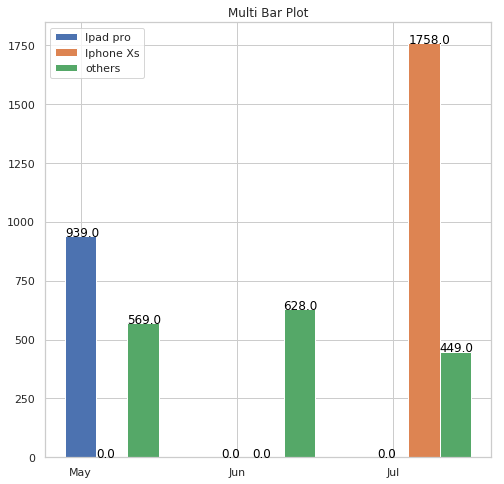

In [4]:

sns.set(style="whitegrid") # Plot style, default matplotlib is ugly


fig = plt.figure(figsize=(8, 8))  # create figure

ax = fig.add_subplot(111)


ind = np.arange(5,8)    # the x locations for the groups

width = 0.2         # the width of the bars

p1 = ax.bar(ind, df['Iphone Xs'], width)


p2 = ax.bar(ind + width, df['Ipad pro'], width)

p3 = ax.bar(ind + width + width, df['others'], width)


ax.set_title('Multi Bar Plot')

ax.set_xticks(ind )
ax.set_xticklabels(('May', 'Jun', 'Jul'))



ax.legend((p1[0], p2[0], p3[0]), ('Ipad pro', 'Iphone Xs','others'))
ax.autoscale_view()


for patch in ax.patches:
        ax.annotate('{:}'.format(patch.get_height()), (patch.get_x(), patch.get_height()), color='black')

plt.show() 


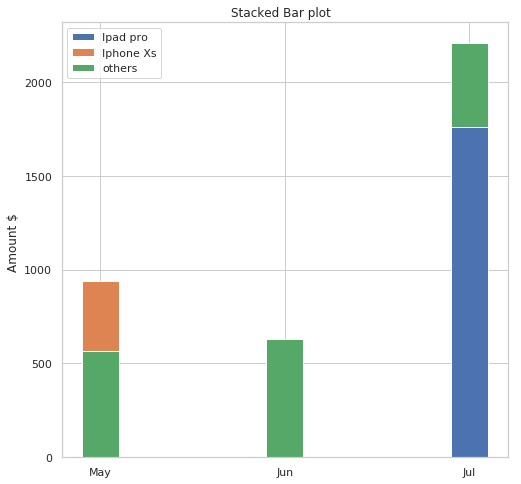

In [5]:
ind = np.arange(5,8)   # the x locations for the groups
width = 0.20       


fig = plt.figure(figsize=(8, 8))  # create figure

ax = fig.add_subplot(111)

p1 = plt.bar(ind, df['Ipad pro'] , width ,
)


p2 = plt.bar(ind, df['Iphone Xs'], width,
             bottom=df['Ipad pro'])


p3 = plt.bar(ind,df['others'],width,
            bottom = df['Ipad pro']);

plt.ylabel('Amount $ ')
plt.title('Stacked Bar plot  ')
plt.xticks(ind, ('May', 'Jun', 'Jul'))
plt.yticks(np.arange(0, 2500, 500))
plt.legend((p1[0], p2[0], p3[0]), ('Ipad pro', 'Iphone Xs','others'));



A more effortless way with seaborn 

,month,product,value
0,5,Ipad pro,0.0
1,6,Ipad pro,0.0
2,7,Ipad pro,1758.0
3,5,Iphone Xs,939.0
4,6,Iphone Xs,0.0
5,7,Iphone Xs,0.0
6,5,others,569.0
7,6,others,628.0
8,7,others,449.0


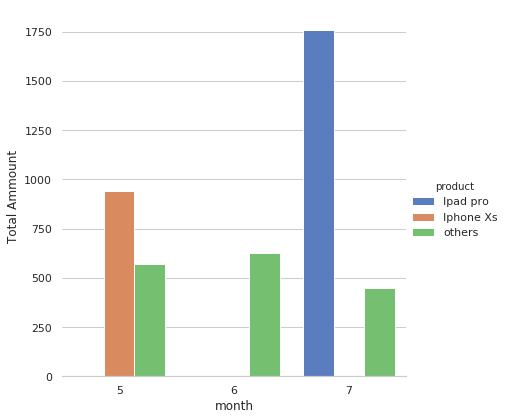

In [6]:
# We need to rearrange our data in orther to plot it to have every different product type 
#for each different month with the right amount associated with it

df =  pd.melt(df, id_vars=['month'], var_name='product', value_name='value')

display(df)

sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="month", y="value", hue="product", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Total Ammount ");
